In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import Levenshtein
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

In [3]:
df = pd.read_csv("RedeSocial.csv")

In [4]:
df

,Nome,Idade,Educacao,Perfil
0,Paulo,48,1.0,Mau
1,Mónica,43,2.0,Bom
2,Helena,82,3.0,Mau
3,Eva,23,3.0,Mau
4,Filipe,46,5.0,Bom
5,Irene,29,4.5,Mau
6,José,42,4.1,Bom
7,Sofia,38,5.0,Mau
8,Maria,31,3.0,Bom
9,Pedro,41,1.0,Bom


In [5]:
data = df.copy()
# Converter para valor binário
data["Perfil"].replace(["Bom", "Mau"], [1, 0], inplace=True)

# Standardizar
data["Idade"] = (data["Idade"] - data["Idade"].mean()) / data["Idade"].std()
data["Educacao"] = (data["Educacao"] - data["Educacao"].mean()) / data["Educacao"].std()
data

,Nome,Idade,Educacao,Perfil
0,Paulo,0.422075,-1.869921,0
1,Mónica,0.120593,-1.092407,1
2,Helena,2.472156,-0.314893,0
3,Eva,-1.085337,-0.314893,0
4,Filipe,0.301482,1.240134,1
5,Irene,-0.723558,0.851378,0
6,José,0.060296,0.540372,1
7,Sofia,-0.180889,1.240134,0
8,Maria,-0.602965,-0.314893,1
9,Pedro,0.000000,-1.869921,1


1. Usando o conjunto de dados da rede social, execute o algoritmo k-means para diferentes valores 
de k e identifique o melhor valor para a quantidade de clusters a utilizar. O que conclui quanto à 
classificação de perfil utilizada no dataset original? 

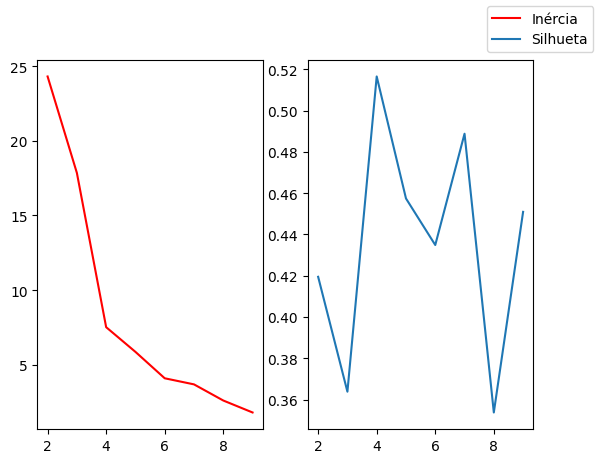

In [6]:
k = range(2,10)
data.drop(["Nome"], inplace=True, axis=1)

inertia = dict()
silhueta = dict()

f, (ax1, ax2) = plt.subplots(1, 2)

for i in k:
    kmean = KMeans(n_clusters=i, n_init="auto")
    kmean.fit(data)
    inertia[i] = kmean.inertia_
    silhueta[i] = silhouette_score(data, kmean.labels_)

ax1.plot(inertia.keys(), inertia.values(), label="Inércia", color = 'r')
ax2.plot(silhueta.keys(), silhueta.values(), label = "Silhueta")
f.legend()

O K-Means vai criar clusters inicialmente, depois irá calcular os centróides para cada cluster e reavaliar o cluster a que pertence cada registo e depois irá novamente recalcular os centróides e assim sucessivamente até mais nenhum registo trocar de cluster.

A silhueta compara densidade e separação dos registos dos clusters, tendo valores entre [-1, 1], quanto mais próximo de 1 tem-se o valor ideal de densidade e separação.

O método do cotovelo que usa a inércia, usa apenas a densidade dos registos dos clusters (o quão próximos estão os registos de cada cluster), o ponto de "viragem" da curva dá o melhor número de clusters.

Sendo assim 4 é o número ideal de clusters.

In [7]:
kmean = KMeans(n_clusters=2, n_init="auto")
classifier = kmean.fit(data)
labels_kmeans = classifier.fit_predict(data)

print("Silhueta: ", silhouette_score(data, labels_kmeans))

Silhueta:  0.4654842018386451


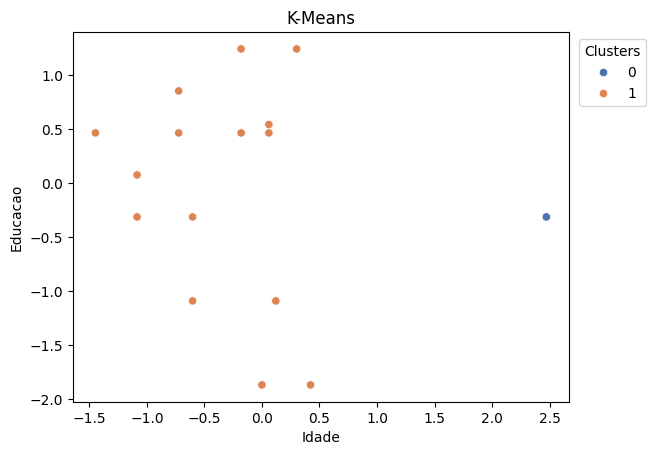

In [8]:
p = sns.scatterplot(data = data, x = 'Idade', y = 'Educacao', hue = labels_kmeans, legend = "full", palette = "deep")
p.set(title='K-Means')
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')

2. Usando o conjunto de dados da rede social, execute o algoritmo DBSCAN e teste valores 
diferentes para os dois hiperparâmetros principais. Indique o número de clusters e pontos de ruído 
resultantes. 

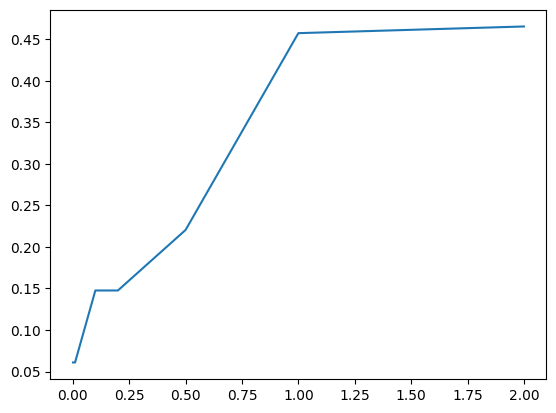

In [9]:
silhueta = dict()


for i in [0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 2.0]:
    dbscan = DBSCAN(min_samples=2, eps=i)
    dbscan.fit(data)
    labels_dbscan = dbscan.fit_predict(data)

    silhueta[i] = silhouette_score(data, labels_dbscan)

plt.plot(silhueta.keys(), silhueta.values(), label = "Silhueta")

O DBSCAN faz uso da densidade, ou seja, ele quer agrupar um certo número de vizinhos que tenham uma certas distância máxima, para garantir clusters com uma boa densidade. Para isso temos de passar o máxima de registos para uma vizinhança e a distância mínima para ser considerado da vizinhança `eps`.

Através da silhueta pode-se observar que a distância de 1.0 para vizinhanças de no mínimo 2 registos, é o que aumenta mais a silhueta. Logo poderá ser um bom valor para o `eps` do DBSCAN.

O cluster -1 é o cluster de registos que não ficaram em nenhuma vizinhança.

In [10]:
dbscan = DBSCAN(min_samples=2, eps=1.0)
dbscan.fit(data)
labels_dbscan = dbscan.fit_predict(data)
print("N clusters: ", len(np.unique(dbscan.labels_)) - 1)
print("Pontos de ruído: ", np.count_nonzero(dbscan.labels_ == -1))

N clusters:  4
Pontos de ruído:  1


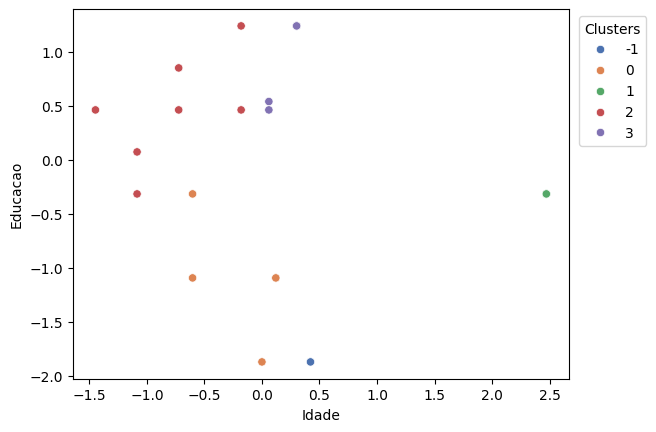

In [11]:
p = sns.scatterplot(data = data, x = 'Idade', y = 'Educacao', hue = labels_dbscan, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')

3. Usando o conjunto de dados da rede social, execute o algoritmo hierárquico aglomerativo e 
plote o dendrograma gerado. Utilize 'linkage' para definir o cálculo de distância como 'ward', e 
'dendrogram' para fazer o gráfico. Ambos pertencem ao modulo scipy.cluster.hierarchy (from 
scipy.cluster.hierarchy import dendrogram, linkage). 

In [12]:
aglomerative = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="ward")
model = aglomerative.fit(data)

In [13]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

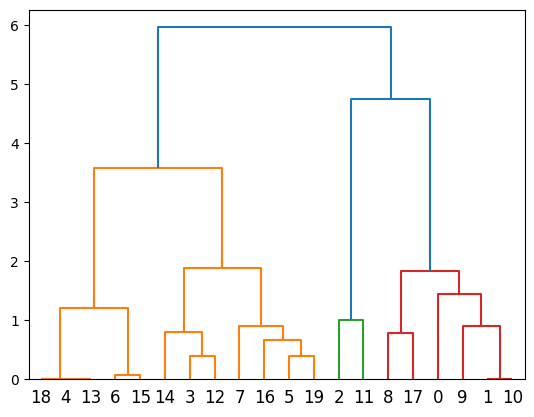

In [14]:
plot_dendrogram(model)

A hierarquia aglomerativa, inicialmente ele vai calcular a distância entre registos e vai criar um cluster com os 2 registos com distância mínima. 

A "distância" não tem de ser euclideana, podem ser usados outros métodos. Neste caso, o `ward` irá calcular a variância entre clusters e criar clusters cuja variância é mínima.

Pode verificar-se que foram selecionados 4 clusters, tendo o mesmo resultado que o K-Means e o DBSCAN.

4. O que acontece se alterar a ordem em que apresenta os dados ao algoritmo k-means? Use o 
conjunto de dados da rede social e o método ‘elbow’ para descobrir.

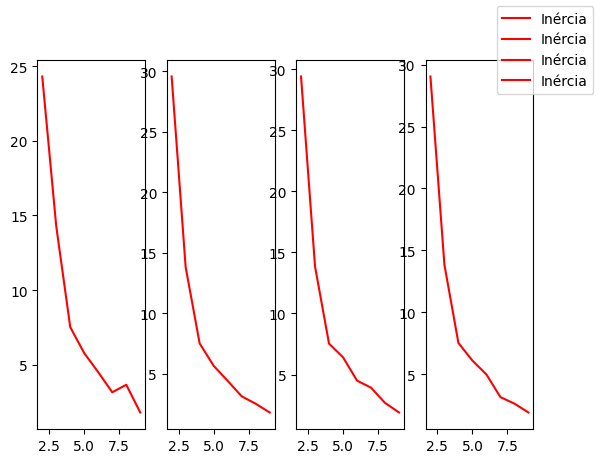

In [16]:
k = range(2,10)

f, ax = plt.subplots(1, 4)

for j in range(4):
    inertia = dict()
    
    for i in k:
        kmean = KMeans(n_clusters=i, n_init="auto")
        kmean.fit(data)
        inertia[i] = kmean.inertia_
        silhueta[i] = silhouette_score(data, kmean.labels_)
    
    ax[j].plot(inertia.keys(), inertia.values(), label="Inércia", color = 'r')

f.legend()

Apesar de haver variação, é muito pouca, o que significa que como o KMeans já seleciona registos de forma aleatória, estes estarem em ordem diferente não impacta no resultado.

5. Calcule a distância de edição entre "composição" e "conceção". 

In [18]:
str1 = "composição"
str2 = "conceção"

Levenshtein.distance(str1, str2)

5